In [31]:
import pandas as pd
import numpy as np

In [32]:
#pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org pydot graphviz

In [33]:
import tensorflow as tf

In [34]:
import missingno as msno

In [35]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Concatenate, Dense, Dropout, Embedding, Input, Reshape
import matplotlib.pyplot as plt

In [36]:
%matplotlib inline

In [37]:
x_train = pd.read_csv('X_train_N1UvY30.csv')
x_test = pd.read_csv('X_test_m4HAPAP.csv')

In [38]:
y_train = pd.read_csv('y_train_or6m3Ta.csv')
y_test = pd.read_csv('y_random_cfm.csv')

<Axes: >

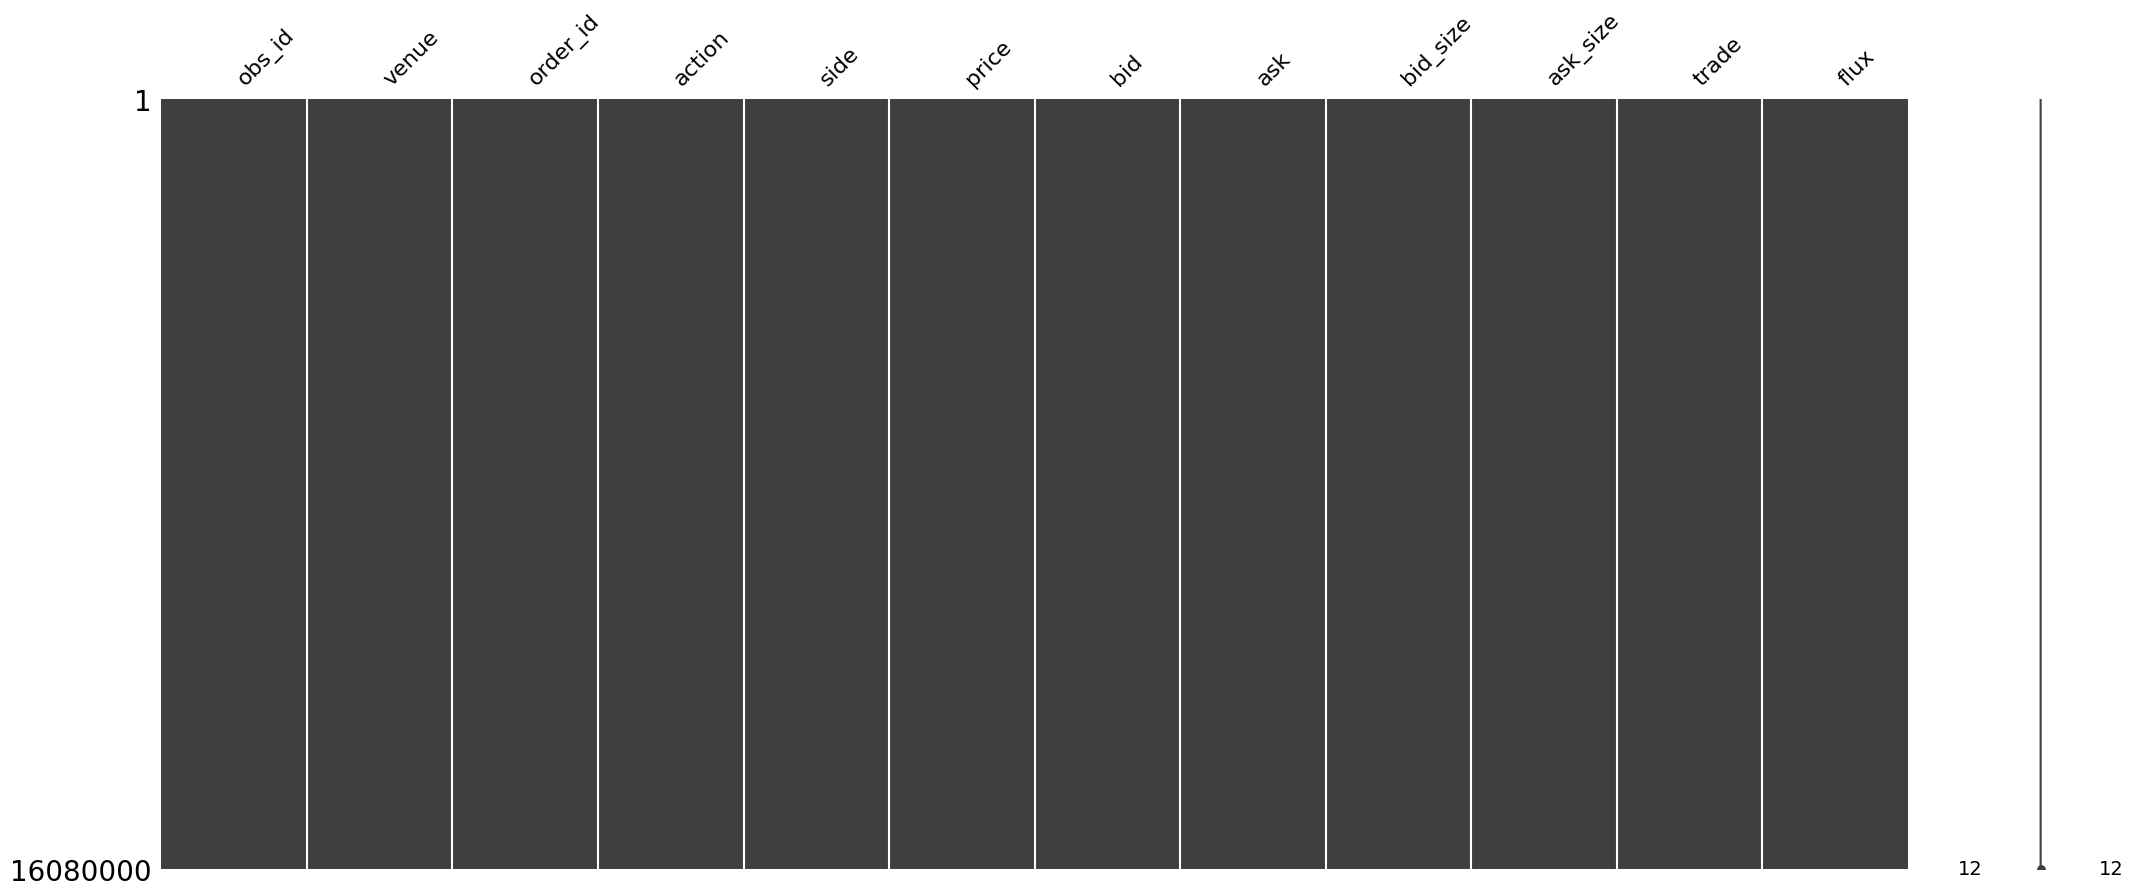

In [39]:
msno.matrix(x_train)

In [81]:
y_train.

array([ 8, 14,  5, ..., 22, 16, 17], dtype=int64)

In [41]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16080000 entries, 0 to 16079999
Data columns (total 12 columns):
 #   Column    Dtype  
---  ------    -----  
 0   obs_id    int64  
 1   venue     int64  
 2   order_id  int64  
 3   action    object 
 4   side      object 
 5   price     float64
 6   bid       float64
 7   ask       float64
 8   bid_size  int64  
 9   ask_size  int64  
 10  trade     bool   
 11  flux      int64  
dtypes: bool(1), float64(3), int64(6), object(2)
memory usage: 1.3+ GB


In [42]:
from sklearn.preprocessing import OrdinalEncoder

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Embedding, Bidirectional, Concatenate, Input, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [44]:
df = x_train.copy()

In [45]:
# Normalize prices
"""
Cela a pour effet de normaliser les prix par rapport à la première valeur de bid de chaque séquence, 
ce qui peut aider à réduire la variance entre les séquences et mettre en évidence les motifs relatifs au lieu de valeurs absolues,
facilitant ainsi l'apprentissage du modèle. Cela met l'accent sur les mouvements relatifs des prix au sein de la séquence plutôt que sur les valeurs absolues des prix. 
Les mouvements relatifs peuvent être plus informatifs pour identifier les caractéristiques d'une action, 
car ils reflètent la dynamique du marché indépendamment du niveau de prix absolu de l'action.
"""
df['price'] -= df.groupby('obs_id')['bid'].transform('first')
df['bid'] -= df.groupby('obs_id')['bid'].transform('first')
df['ask'] -= df.groupby('obs_id')['ask'].transform('first')

In [46]:
# Encode categorical variables
action_encoder = LabelEncoder()
df['action'] = action_encoder.fit_transform(df['action'])
trade_encoder = LabelEncoder()
df['trade'] = trade_encoder.fit_transform(df['trade'])
venue_encoder = LabelEncoder()
df['venue'] = venue_encoder.fit_transform(df['venue'])

In [47]:
# Normalisation Z-score pour 'price'
df['price'] = (df['price'] - df['price'].mean()) / df['price'].std()

# Normalisation Z-score pour 'bid_size'
df['bid_size'] = (df['bid_size'] - df['bid_size'].mean()) / df['bid_size'].std()

# Normalisation Z-score pour 'flux'
df['flux'] = (df['flux'] - df['flux'].mean()) / df['flux'].std()


In [48]:
df

,obs_id,venue,order_id,action,side,price,bid,ask,bid_size,ask_size,trade,flux
0,0,4,0,0,A,-0.002671,0.00,0.00,-0.445946,1,0,0.686083
1,0,4,1,0,B,-0.004831,0.00,0.00,-0.445946,1,0,0.686083
2,0,4,2,1,A,-0.002763,0.00,0.00,-0.445946,1,0,-0.686455
3,0,4,3,0,A,-0.002671,0.00,0.00,-0.445946,1,0,0.686083
4,0,4,4,1,A,-0.002350,0.00,0.00,-0.445946,1,0,-0.686455
...,...,...,...,...,...,...,...,...,...,...,...,...
16079995,160799,4,61,1,A,0.002016,0.01,0.03,0.412520,261,0,-0.686455
16079996,160799,0,70,0,A,-0.003774,0.01,0.03,0.412520,361,0,0.686083
16079997,160799,4,71,0,A,0.001741,0.01,0.03,0.412520,361,0,0.686083
16079998,160799,4,72,0,A,0.001741,0.01,0.03,0.412520,361,0,0.686083


In [49]:
# Feature engineering
features = ['venue', 'action', 'trade', 'bid', 'ask', 'price', 'bid_size', 'ask_size', 'flux']
X = df[features].values.reshape(-1, 100, len(features))

In [50]:
# Si y_train est une série pandas ou une liste:
y_train_n = np.array(y_train['eqt_code_cat'])  # Convertir y_train en un tableau Numpy si ce n'est pas déjà le cas.

# Répéter chaque élément 10 fois
y_train_repeated = np.repeat(y_train_n, 100)

In [51]:
y_train_repeated

array([10, 10, 10, ...,  5,  5,  5], dtype=int64)

In [52]:
# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_train_repeated)
y = y.reshape(-1, 100)[:, 0]  # Assuming each 100-row block has the same label

In [53]:
y

array([10, 15,  0, ...,  3, 11,  5], dtype=int64)

In [54]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model

# Separate inputs for each categorical feature
venue_input = Input(shape=(100,), dtype='int32')
action_input = Input(shape=(100,), dtype='int32')
trade_input = Input(shape=(100,), dtype='int32')

# Embedding for each categorical feature
venue_embedding = Embedding(input_dim=len(venue_encoder.classes_), output_dim=8)(venue_input)
action_embedding = Embedding(input_dim=len(action_encoder.classes_), output_dim=8)(action_input)
trade_embedding = Embedding(input_dim=len(trade_encoder.classes_), output_dim=8)(trade_input)

# Assume we have continuous features as well
continuous_input = Input(shape=(100, len(features) - 3))

# Concatenate the outputs of the embedding layers and the continuous features
concatenated = Concatenate()([venue_embedding, action_embedding, trade_embedding, continuous_input])  # Add continuous_input in the list if you have continuous features

# Now apply the GRU layers
bi_gru_1 = Bidirectional(GRU(64, return_sequences=True))(concatenated)
bi_gru_2 = Bidirectional(GRU(64))(bi_gru_1)

# Apply Dense layers
dense_layer = Dense(64, activation='selu')(bi_gru_2)
output_layer = Dense(len(label_encoder.classes_), activation='softmax')(dense_layer)

# Define the model
model = Model(inputs=[venue_input, action_input, trade_input, continuous_input], outputs=output_layer)  # Add continuous_input to the inputs list if you have continuous features

# Compile the model
model.compile(optimizer=Adam(learning_rate=3e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [56]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, 100, 8)               48        ['input_5[0][0]']             
                                                                                            

In [57]:
# Convert categorical features for embedding
X_train_venue = df['venue'].values.reshape(-1, 100)
X_train_action = df['action'].values.reshape(-1, 100)
X_train_trade = df['trade'].values.reshape(-1, 100)

# Assuming continuous features don't need embedding and are already normalized
continuous_features = ['bid', 'ask', 'price', 'bid_size', 'ask_size', 'flux']
X_train_continuous = df[continuous_features].values.reshape(-1, 100, len(continuous_features))

In [58]:
# Train the model, making sure to pass the correct inputs for each type of feature
history = model.fit([X_train_venue, X_train_action, X_train_trade, X_train_continuous],
                y,
                batch_size=1000,  # Supposons que vous souhaitez utiliser une taille de lot de 1000
                epochs=20)  # Add X_train_continuous if you have continuous features

Epoch 1/20
161/161 [==============================] - 293s 2s/step - loss: 2.8212 - accuracy: 0.1054
Epoch 2/20
161/161 [==============================] - 284s 2s/step - loss: 2.5828 - accuracy: 0.1624
Epoch 3/20
161/161 [==============================] - 275s 2s/step - loss: 2.4391 - accuracy: 0.2074
Epoch 4/20
161/161 [==============================] - 283s 2s/step - loss: 2.3416 - accuracy: 0.2405
Epoch 5/20
161/161 [==============================] - 279s 2s/step - loss: 2.2173 - accuracy: 0.2810
Epoch 6/20
161/161 [==============================] - 285s 2s/step - loss: 2.0877 - accuracy: 0.3214
Epoch 7/20
161/161 [==============================] - 287s 2s/step - loss: 1.9882 - accuracy: 0.3516
Epoch 8/20
161/161 [==============================] - 271s 2s/step - loss: 1.8916 - accuracy: 0.3823
Epoch 9/20
161/161 [==============================] - 278s 2s/step - loss: 1.8177 - accuracy: 0.4028
Epoch 10/20
161/161 [==============================] - 275s 2s/step - loss: 1.7659 - accura

In [60]:
# Préparation des données de test, si vous avez différentes caractéristiques pour des inputs séparés
#X_test_venue = ...
#X_test_action = ...
#X_test_trade = ...
#X_test_continuous = ...

# Évaluation du modèle avec les données de test préparées
loss, accuracy = model.evaluate([X_train_venue, X_train_action, X_train_trade, X_train_continuous], y)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


5025/5025 [==============================] - 217s 43ms/step - loss: 1.3314 - accuracy: 0.5566
Test Loss: 1.3313932418823242
Test Accuracy: 0.5565609335899353


In [61]:
x_test

,obs_id,venue,order_id,action,side,price,bid,ask,bid_size,ask_size,trade,flux
0,0,4,0,A,A,0.15,0.0,0.15,511,100,False,100
1,0,2,1,D,A,0.16,0.0,0.15,511,100,False,-100
2,0,4,2,D,A,1.63,0.0,0.15,511,100,False,-100
3,0,4,3,A,A,1.62,0.0,0.15,511,100,False,100
4,0,2,4,A,A,0.15,0.0,0.15,511,200,False,100
...,...,...,...,...,...,...,...,...,...,...,...,...
8159995,81599,2,57,A,B,-0.01,0.0,0.09,10,541,False,100
8159996,81599,2,57,D,B,-0.01,0.0,0.09,10,541,False,-100
8159997,81599,4,58,A,A,0.10,0.0,0.09,10,641,False,71
8159998,81599,4,59,A,A,0.10,0.0,0.09,10,641,False,100


In [62]:
# Normalize prices
"""
Cela a pour effet de normaliser les prix par rapport à la première valeur de bid de chaque séquence, 
ce qui peut aider à réduire la variance entre les séquences et mettre en évidence les motifs relatifs au lieu de valeurs absolues,
facilitant ainsi l'apprentissage du modèle. Cela met l'accent sur les mouvements relatifs des prix au sein de la séquence plutôt que sur les valeurs absolues des prix. 
Les mouvements relatifs peuvent être plus informatifs pour identifier les caractéristiques d'une action, 
car ils reflètent la dynamique du marché indépendamment du niveau de prix absolu de l'action.
"""
df1 = x_test.copy()
df1['price'] -= df1.groupby('obs_id')['bid'].transform('first')
df1['bid'] -= df1.groupby('obs_id')['bid'].transform('first')
df1['ask'] -= df1.groupby('obs_id')['ask'].transform('first')

In [63]:
# Encode categorical variables
#action_encoder = LabelEncoder()
df1['action'] = action_encoder.transform(df1['action'])
#trade_encoder = LabelEncoder()
df1['trade'] = trade_encoder.transform(df1['trade'])
#venue_encoder = LabelEncoder()
df1['venue'] = venue_encoder.transform(df1['venue'])

In [66]:
# Normalisation Z-score pour 'price'
df1['price'] = (df1['price'] - df1['price'].mean()) / df1['price'].std()

# Normalisation Z-score pour 'bid_size'
df1['bid_size'] = (df1['bid_size'] - df1['bid_size'].mean()) / df1['bid_size'].std()

# Normalisation Z-score pour 'flux'
df1['flux'] = (df1['flux'] - df1['flux'].mean()) / df1['flux'].std()

In [67]:
# Feature engineering
features = ['venue', 'action', 'trade', 'bid', 'ask', 'price', 'bid_size', 'ask_size', 'flux']
X_test = df1[features].values.reshape(-1, 100, len(features))

In [68]:
# Convert categorical features for embedding
X_test_venue = df1['venue'].values.reshape(-1, 100)
X_test_action = df1['action'].values.reshape(-1, 100)
X_test_trade = df1['trade'].values.reshape(-1, 100)

# Assuming continuous features don't need embedding and are already normalized
continuous_features = ['bid', 'ask', 'price', 'bid_size', 'ask_size', 'flux']
X_test_continuous = df1[continuous_features].values.reshape(-1, 100, len(continuous_features))

In [70]:
predictions = model.predict([X_test_venue, X_test_action, X_test_trade, X_test_continuous])

2550/2550 [==============================] - 102s 39ms/step


In [75]:
# Obtenir les classes prédites à partir des probabilités
predicted_classes = np.argmax(predictions, axis=1)

In [80]:
predicted_classes

array([18,  3, 19, ..., 12, 21,  8], dtype=int64)

In [77]:
# Convertir les entiers prédits en labels originaux
predicted_labels = label_encoder.inverse_transform(predicted_classes)

In [78]:
predicted_labels

array([18,  3, 19, ..., 12, 21,  8], dtype=int64)

In [84]:
y_test.drop('eqt_code_cat', axis=1, inplace=True)

In [86]:
y_test['eqt_code_cat'] = predicted_labels

In [88]:
y_test.to_csv('y_test_predicted.csv', index=False)